In [1]:
# We import the modules needed.
import sys, os, datetime
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
import utils.utils as utils
from IPython.display import clear_output
import h5py

In [2]:
gpu_id = 0
os.environ["CUDA_VISIBLE_DEVICES"] = "{0}".format(gpu_id)

In [3]:
mnisttrain = utils.load_mnist("../data/","train")
mnisttest = utils.load_mnist("../data/","t10k")
train_data = mnisttrain[0]
train_label = mnisttrain[1]
test_data = mnisttest[0]
test_label = mnisttest[1]
np.unique(train_label)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)
# Reshape to image for visualization
train_data = mnist.train.images
train_label = mnist.train.labels
test_data = mnist.test.images
test_label = mnist.test.labels

In [4]:
train_dataSet = utils.DataSet(train_data, train_label)
test_dataSet = utils.DataSet(test_data, test_label)

In [5]:
# Create model using wrappers
# the model is identical
def discriminator(x, reuse = False):
    with tf.variable_scope("discriminator", reuse=reuse):
        # 1st conv-layer block
        x = tf.reshape(x, [-1, 28, 28, 1]) # bwhc
        conv_1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.elu)
        bn_1 = tf.layers.batch_normalization(conv_1)
        conv_2 = tf.layers.conv2d(bn_1, 64, 5, activation=tf.nn.elu)
        bn_2 = tf.layers.batch_normalization(conv_2)
        conv_3 = tf.layers.conv2d(bn_2, 128, 5, activation=tf.nn.elu)
        bn_3 = tf.layers.batch_normalization(conv_3)
        flat = slim.flatten(bn_3)
        D_logit = tf.layers.dense(flat, 1, activation=None)
        D_prob = tf.nn.sigmoid(D_logit)
    return D_prob, D_logit

In [6]:
## Create model using wrappers
# the model is identical
def generator(x):
    with tf.variable_scope("generator"):
        fc1=tf.layers.dense(x, 128*7*7, activation=None)
        bn_1 = tf.layers.batch_normalization(fc1)
        reshape = tf.reshape(bn_1, [-1, 7, 7, 128]) # bwhc
        dconv_1 = tf.layers.conv2d_transpose(reshape, 128, 3, strides = 2, padding="same", activation=tf.nn.elu)
        bn_2 = tf.layers.batch_normalization(dconv_1)
        conv_2 = tf.layers.conv2d(bn_2, 128, 5, padding="same", activation=tf.nn.elu)
        bn_3 = tf.layers.batch_normalization(conv_2)
        dconv_2 = tf.layers.conv2d_transpose(bn_3, 64, 5, strides = 2, padding="same", activation=tf.nn.elu)
        bn_4 = tf.layers.batch_normalization(dconv_2)
        out = tf.layers.conv2d(bn_4, 1, 5, padding="same", activation=tf.nn.elu)     
        print(out)
    return out

## Create model using wrappers
# the model is identical
def generator(x):
    with tf.variable_scope("generator"):
        fcn1 = tf.layers.dense(x, 128, activation=tf.nn.relu)
        out = tf.layers.dense(fcn1, 784, activation=tf.nn.sigmoid)
    return out

def discriminator(x, reuse = False):
    with tf.variable_scope("discriminator", reuse = reuse):
        # 1st conv-layer block
        fcn1 = tf.layers.dense(x, 128, activation=tf.nn.relu)
        D_logit = tf.layers.dense(fcn1, 1, activation=None)
        D_prob = tf.nn.sigmoid(D_logit)
    return D_prob, D_logit

In [7]:
# Parameters for the neural net
# step size for gradient decsent
learning_rate = 0.001
#Iterations of forward and back pass
training_iters = 2**24

#size of each batch used for forward/backwards pass
batch_size = 128
display_step = 256
mb_size = 128
Z_dim = 100

tf.reset_default_graph()
# tf Graph input
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 28 * 28])
    y = tf.placeholder(tf.int64, None)
    keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
    Z = tf.placeholder(tf.float32, shape=[None, 100], name='Z')

In [8]:
# Define loss and optimizer
G_sample = generator(Z)
D_real, D_logit_real = discriminator(x)
D_fake, D_logit_fake = discriminator(G_sample, reuse = True)

Tensor("generator/conv2d_2/Elu:0", shape=(?, 28, 28, 1), dtype=float32)


In [9]:
with tf.name_scope('loss'):
    #find mean loss of batch
    #D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
    #G_loss = -tf.reduce_mean(tf.log(D_fake))
    # Alternative loss functions
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
    D_loss = D_loss_real + D_loss_fake
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

with tf.name_scope('optimizer'):
    theta_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"generator")
    theta_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"discriminator")
    # Update D(X)'s parameters
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon=0.01)
    D_min = D_solver.minimize(D_loss, var_list=theta_D)

    # Update G(Z)'s parameters
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon=0.01)
    G_min = G_solver.minimize(G_loss, var_list=theta_G)

# Add scalars to Tensorboard
dloss=tf.summary.scalar("Disc_Loss", D_loss)
gloss=tf.summary.scalar("Gen_Loss", G_loss)
tf.contrib.layers.summarize_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
merged_summaries = tf.summary.merge_all()

# Initializing the variables
init = tf.global_variables_initializer()

In [10]:
# Name for tensorboard.
tb_path = utils.makeTbPath()

Currently: 3.3203125%
(16, 28, 28, 1)
(16, 28, 28, 1)


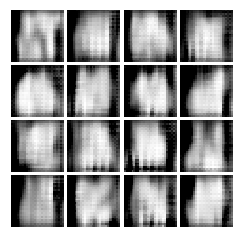

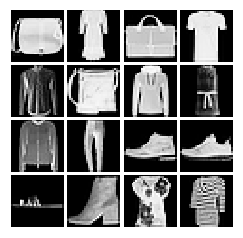

In [11]:
# Launch the graph
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(tb_path, sess.graph)
disc_output = [D_min, D_loss, merged_summaries]
gen_output = [G_min, G_loss, gloss]
try:
    step = 1
    # Keep training until max iterations is reached
    while step * batch_size < training_iters:
        # load first batch
        X_mb, _ = train_dataSet.next_batch(mb_size)
        feed_dict_disc = {x: X_mb, Z: utils.sample_Z(mb_size, Z_dim)}
        feed_dict_gen = {Z: utils.sample_Z(mb_size, Z_dim)}
        _, D_loss_curr, summaryD = sess.run(disc_output, feed_dict=feed_dict_disc)
        _, G_loss_curr, summaryG = sess.run(gen_output, feed_dict=feed_dict_gen)

        # Testing step see if data is converging
        if step % display_step == 0:
            clear_output()
            prec = ((step * batch_size)/training_iters)*100
            print("Currently: "+ str(prec)+"%")
            samples = sess.run(G_sample, feed_dict={Z: utils.sample_Z(16, Z_dim)})
            print(samples.shape)
            fig = utils.plot(samples)
            print(samples.shape)
            #plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')

            plt.show()
            plt.close(fig)
            fig2 = utils.plot(X_mb[:16])
            plt.show()
            plt.close(fig2)
            writer.add_summary(summaryD, step)
            #writer.add_summary(summaryD, step)
            #writer.add_summary(summaryG, step)
        step += 1

    print("\nOptimization Finished!, Training GLOSS = {:.3f}".format(G_loss_curr))

except KeyboardInterrupt:
    pass

In [12]:
def sample_D(m, n):
    return np.random.uniform(-1., -1., size=[m, n])

samples = sess.run(G_sample, feed_dict={Z: sample_D(1, Z_dim)})

In [13]:
fig = plot(samples)
plt.show()

NameError: name 'plot' is not defined